#  <font color='black'>Notes</font>

First updated: Feb 07, 2023

Last updated: 00:17 am, Feb 14, 2023

To do:
- include normalization in atom counting
- include factor of 0.5 in $\sigma_0$ for Top 
- update generic_data_filter to handle data frames, so that we can update good_shot flag in data_frame after passing it through this function
- work on fitting RF resonance data... find more clever ways to do this

#  <font color='black'>Setting up</font>

##  <font color=#399FD5>Collapsible Headings</font>

Run the following commands in anaconda prompt to install a graphical interface for configuring collapsible headings and other extentions/plugins from within the notebooks:

pip install jupyter_contrib_nbextensions

jupyter contrib nbextension install --user

jupyter nbextensions_configurator enable --user

Once done, go to Jupyter notebook --> Nbextensions --> check the "Collapsible Headings" box

## <font color=#399FD5>Imports</font>

In [98]:
from tkinter import Tk
from tkinter import filedialog # for prompting user to set analysis folder
import glob
import json
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import scipy
import pandas as pd
from tqdm import tqdm

## <font color=#399FD5>Suppress Warnings</font>

In [5]:
import warnings
warnings.filterwarnings('ignore')

## <font color=#399FD5>Constants</font>

In [6]:
ABSORPTION_LIMIT = 5.0
SPECIAL_CHARACTERS = "!@#$%^&*()-+?_=,<>/"

# Lithium constants
mLi6 = 0
Li6D2Gamma = 5.8724 # MHz
Li6D2lambda0 = 670.977338*10**(-9) # meters
Li6D2sigma0 = 3*(Li6D2lambda0)**2/(2*np.pi)

# Convenience functions

## <font color=#399FD5>Construct file paths</font>

In [7]:
# construct file fullpath from folder_path and run_id

def construct_file_fullpath(folder_path, run_id = 'something random'):
    files_fullpath = sorted(glob.glob(folder_path + '/*.fits'))
    current_file_fullpath = files_fullpath[0]
    for f in files_fullpath:
        if run_id in f:
            current_file_fullpath = f
    return current_file_fullpath

## <font color=#399FD5>Get run parameters</font>

In [8]:
def get_run_param_from_filename(folder_path, current_file_fullpath, param):
    '''
    get a single parameter value from a file
    '''
    param_for_filename = 0 
    metadata_fullpath = folder_path + "/run_params_dump.json"
    with open(metadata_fullpath, 'r') as json_file:
        metadata_dict = json.load(json_file)  
    name = str(current_file_fullpath.split(folder_path)[1]).replace('\\',"")
    run_id = name.split('_')[0] 
    run_id = "".join(ch for ch in run_id if ch.isalnum() ) # extract run_id out of folder name
    # get params for this run_id
    params_for_run_id = metadata_dict[run_id]    
    param_for_filename = params_for_run_id[param]
    
    return param_for_filename

In [29]:
# for each folder, get list of run parameters
def get_run_params(folder_path, params):
    '''
    params: list of param names
    returns a list of dictionaries
    '''
    params_for_folder = [] # this is a list of dictionaries
    metadata_fullpath = folder_path + "/run_params_dump.json"
    with open(metadata_fullpath, 'r') as json_file:
        metadata_dict = json.load(json_file)  
    for f in sorted(glob.glob(folder_path + '/*.fits')): # for every fits file in folder
        name = str(f.split(folder_path)[1]).replace('\\',"")
        run_id = name.split('_')[0] 
        run_id = "".join(ch for ch in run_id if ch.isalnum() )
        # get params for this run_id
        params_for_run_id = metadata_dict[run_id]    
        param_dict = dict()
        for param in params:
            param_dict[param] = params_for_run_id[param]
        params_for_folder.append(param_dict)
    return params_for_folder

### EXAMPLE CODE: ####
# params = get_run_params(folder_path, params = ['LFImgFreq', 'SideGreenEvap', 'IREvap'])

In [109]:
def get_run_params_for_data_frame(folder_path, params):
    '''
    params: list of param names [p1,p2,...]
    returns a dictionary of the form {p1: [], p2: [],...}
    '''
    params_for_folder = dict() # this is a dict() of lists
    # initial params_for_folder:
    for p in params:
        params_for_folder[p] = []
    
    metadata_fullpath = folder_path + "/run_params_dump.json"
    with open(metadata_fullpath, 'r') as json_file:
        metadata_dict = json.load(json_file)  
        
    for f in sorted(glob.glob(folder_path + '/*.fits')): # for every fits file in folder
        name = str(f.split(folder_path)[1]).replace('\\',"")
        run_id = name.split('_')[0] 
        run_id = "".join(ch for ch in run_id if ch.isalnum() )
        # get params for this run_id
        params_for_run_id = metadata_dict[run_id]
        for k in params_for_folder.keys():
            params_for_folder[k].append(params_for_run_id[k])
    return params_for_folder

### EXAMPLE CODE: ####
# params = get_run_params(folder_path, params = ['LFImgFreq', 'SideGreenEvap', 'IREvap'])

## <font color=#399FD5>Display image</font>

In [10]:
# function for safely handling subtractions...
# Credit: Eric A. Wolf, BEC1@MIT, 2022. 

def safe_subtract(x, y, minimum_cast = np.byte):
    newtype = np.result_type(x, y, minimum_cast)
    return x.astype(newtype) - y.astype(newtype)

In [11]:
# display an image given folder_path, run_id, ROI, and frame_type:
def display_image(current_file_fullpath, ROI, norm_box, 
                  frame_type = 'FakeOD', min_scale=0, max_scale=1.3, brightness=12):
    # set up figure
    fig, ax = plt.subplots()
    
    # read image
    fits_image = fits.open(current_file_fullpath)
    # fits_image.info() # display fits image info
    img = fits_image[0].data
    fits_image.close()

    # get dims of image
    dims = img[0,:,:].shape 
    x_limit = dims[1]
    y_limit = dims[0]

    # then show image:
    if frame_type == 'OD':
        frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
        # clean image: using nan_to_num
        frame = np.nan_to_num(frame, nan=ABSORPTION_LIMIT)
        # fix clipping
        frame = np.clip(frame, 0, ABSORPTION_LIMIT)
        ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
        ax.invert_yaxis()

    else:
        if frame_type == 'FakeOD':
            frame = (safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:]))
            # clean image: using nan_to_num
            frame = np.nan_to_num(frame)
            # fix clipping
            frame = np.clip(frame, 0, ABSORPTION_LIMIT)
            ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
            ax.invert_yaxis()
        else:
            if frame_type == 'With atoms':
                frame = img[0,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Without atoms':
                frame = img[1,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            elif frame_type == 'Dark':
                frame = img[2,:,:]
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**brightness)  # need to adjust gray scale/colormap here with BRIGHTNESS variable
                ax.invert_yaxis()
            else:
                frame = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
                # clean image: using nan_to_num
                frame = np.nan_to_num(frame)
                ax.imshow(frame, cmap='gray', vmin=0, vmax=2**15).set_clim(min_scale, max_scale)
                ax.invert_yaxis()
                
    # Create a roi patch
    width = abs(int(ROI[1]) - int(ROI[0]))
    height = abs(int(ROI[3]) - int(ROI[2]))
    xmin = min(int(ROI[0]), int(ROI[1]))
    ymin = min(int(ROI[2]), int(ROI[3]))
    roi = patches.Rectangle((xmin, ymin), 
                             width, 
                             height, 
                             linewidth=1, 
                             edgecolor='r', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    
    # Create a norm_box patch
    width_norm = abs(int(norm_box[1]) - int(norm_box[0]))
    height_norm = abs(int(norm_box[3]) - int(norm_box[2]))
    xmin_norm = min(int(norm_box[0]), int(norm_box[1]))
    ymin_norm = min(int(norm_box[2]), int(norm_box[3]))
    
    norm_roi = patches.Rectangle((xmin_norm, ymin_norm), 
                             width_norm, 
                             height_norm, 
                             linewidth=1, 
                             edgecolor='g', 
                             facecolor='none')
    # Add the ROI to the Axes
    ax.add_patch(roi)
    ax.add_patch(norm_roi)   
    # show everything
    plt.show()
                
    return (fig, ax)

## <font color=#399FD5>Pixel summing</font>

In [12]:
def get_pixel_sum_single_image(current_file_fullpath, ROI, norm_box):
    # read image
    fits_image = fits.open(current_file_fullpath)
    img = fits_image[0].data
    fits_image.close()

    # get od image, crop, and sum
    od = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
    # now clean od:
    od = np.nan_to_num(od)
    # fix clipping
    od = np.clip(od, 0, ABSORPTION_LIMIT)
    od = od.astype(np.float)
    od_cropped = od[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just OD, but cropped
    norm_od = od[norm_box[2]:norm_box[3], norm_box[0]:norm_box[1]]
    
    od_cropped_area = abs(ROI[3] - ROI[2])*abs(ROI[1] - ROI[0])
    norm_od_area = abs(norm_box[3] - norm_box[2])*abs(norm_box[1] - norm_box[0])
    
    return sum(sum(od_cropped)) - sum(sum(norm_od*od_cropped_area/norm_od_area))

In [102]:
def get_pixel_sum_folder(folder_path, ROI, norm_box, filename_key = '', param = 'id'):
    pixel_sums = []
    param_list = []
    image_list = sorted(glob.glob(folder_path + '/*.fits'))
    for f in image_list:
        if filename_key == '' or filename_key in f:
            pixel_sums.append(get_pixel_sum_single_image(f, ROI, norm_box))
            # now get param list associated with these pixel sums:
            param_list.append(get_run_param_from_filename(folder_path, f, param))
        #print('Progress: ' + str(image_list.index(f) + 1) + '/' + str(len(image_list)))
    pixel_sums = np.array(pixel_sums)
    param_list = np.array(param_list)
    
    return pixel_sums, param_list

In [14]:
def get_pixel_sums_folder_TopAB(folder_path, ROI, norm_box, param_A = 'id', param_B = 'id'):
    pixel_sums_A = []
    pixel_sums_B = []
    param_list_A = []
    param_list_B = []
    image_list = sorted(glob.glob(folder_path + '/*.fits'))        
    for f in image_list:
        if 'TopA' in f:
            pixel_sums_A.append(get_pixel_sum_single_image(f, ROI, norm_box))
            param_list_A.append(get_run_param_from_filename(folder_path, f, param_A))
        elif 'TopB' in f:
            pixel_sums_B.append(get_pixel_sum_single_image(f, ROI, norm_box))
            param_list_B.append(get_run_param_from_filename(folder_path, f, param_B))            
        print('Progress: ' + str(image_list.index(f) + 1) + '/' + str(len(image_list)))
        
    pixel_sums_A = np.array(pixel_sums_A)
    pixel_sums_B = np.array(pixel_sums_B)
    param_list_A = np.array(param_list_A)
    param_list_B = np.array(param_list_B)
    
    return pixel_sums_A, param_list_A, pixel_sums_B, param_list_B

In [107]:
def add_pixel_sums_to_data_frame(df, ROI, norm_box, column_name = 'pixel_sum'):
    pixel_sums = []
    for f in tqdm(df['fullpaths']):
        pixel_sums.append(get_pixel_sum_single_image(f, ROI, norm_box))          
        
    # update dataframe:
    df[column_name] = pixel_sums
    return df

## <font color=#399FD5>Get atom densities from absorption images</font>

Some theory for atom counting. The 2D atom density, including the effect of saturation, is given by 

$n_{2d}(x,y) = \int n_{3d}(x,y,z)\,dz = -\frac{1+I/I_\text{sat}(\omega)}{\sigma(\omega)} \ln \frac{I_f}{I_0} = \frac{1+s\sigma(\omega)/\sigma_0}{\sigma(\omega)} \times \text{OD}, $ 

where $\kappa(\omega, I) = \frac{n_{2d} \sigma(\omega)}{1 + I / I_\text{sat}(\omega)}$ is the absorption coefficient, 
$\sigma(\omega) = \sigma_0 \frac{\Gamma^2/4}{(\omega-\omega_0)^2 + \Gamma^2/4}$, and $\sigma_0 = \frac{3\lambda_0^2}{2\pi}$.

So, after the fit has been done, we know $\omega_0$ and $s$. Since $\sigma_0$ is known, we can calculate $(1+s \sigma(\omega)/\sigma_0)/\sigma(\omega)$ for every shot. From here, we can obtain $n_{2d}$ from knowing the OD (which comes from the image). Finally, to obtain the atom number, we just multiply the atom density $n_{2d}$ by the pixel size and integrate over the entire image to get $N$. 

Notice that we have not considered the fact that for (nearly) blacked out clouds the saturation parameter changes as a function of the line of integration. How might we take this into account? Consider the Beer-Lambert law, which says 

$ \frac{dI}{I} = -\kappa(I, \omega) \,dz = -n\sigma_0 \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,dz \implies \int_{s_0}^{s_f} \frac{1}{s} \frac{\Gamma^2/4}{\delta^2 + (1+s)\Gamma^2/4} \,ds =  -n_{2d}\sigma_0 $.

where we have made the substitution $I \to s I_\text{sat},  I_0 \to s_0 I_\text{sat}, I_f \to s_f I_\text{sat}$ and integrated both sides, simplifying the integrand, we find that

$-n_{2d} \sigma_0 =  \int_{s_0}^{s_f} 1 + \frac{1 + 4\delta^2/\Gamma^2}{s}\,ds = (s_f - s_0) + \left( 1 + \frac{4\delta^2}{\Gamma^2} \right)\ln \frac{s_f}{s_0}.$

From here, the atom density is readily found:

$\boxed{n_{2d} = -\frac{1}{\sigma_0} \left[ \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \ln \frac{I_f}{I_0} +  \frac{I_f - I_0}{I_\text{sat}}\right] =  \frac{1}{\sigma_0} \left( 1 + \frac{4\delta^2}{\Gamma^2} \right) \times od  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} = \frac{od}{\sigma(\omega)}  -\frac{1}{\sigma_0} \frac{I_f - I_0}{I_\text{sat}} } $

One final thing: how do we obtain $I_\text{sat}$? There are several ways to do this, but one way is to obtain the saturation parameter $s$ from the imaging resonance curve fit, and then take the without atom shot and divide it by $s$ to get an approximation for $I_\text{sat}$.

In [15]:
def get_density_abs_single_image(current_file_fullpath, ROI, norm_box, sigma0, sigma, s):
    # read image
    fits_image = fits.open(current_file_fullpath)
    img = fits_image[0].data
    fits_image.close()

    # get od image, crop, and sum
    od = (-np.log(safe_subtract(img[0,:,:], img[2,:,:])/safe_subtract(img[1,:,:], img[2,:,:])))
    # now clean od
    od = np.nan_to_num(od)
    # fix clipping
    od = np.clip(od, 0, ABSORPTION_LIMIT)
    od = od.astype(np.float)
    od_cropped = od[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just OD, but cropped
    
    # Isat will be approimately the Intensity WOA divided by saturation parameter s
    Isat = img[1,:,:].astype(np.float)/s
    
    # ic is (WA - WOA)/Isat/sigma0
    ic = (safe_subtract(img[0,:,:], img[1,:,:])/Isat)/sigma0
    ic = np.nan_to_num(ic)
    ic_cropped = ic[ROI[2]:ROI[3], ROI[0]:ROI[1]] # just ic, but cropped
    
    # n2D = od/sigma(omega), naively, assuming saturation is constant across the cloud
    n2D = od_cropped/sigma - ic_cropped
    
    return n2D

In [199]:
def add_atom_densities_abs_to_data_frame_Side(df, ROI, norm_box, 
                                             sigma0 = Li6D2sigma0,
                                             Gamma = Li6D2Gamma, 
                                             s = 0, 
                                             omega0 = 0,
                                             AOM_factor = -2):
    
    # for now handle saturation parameter separately from data frame
    '''
    s: saturation parameters, default to 0
    Assumes that df already has 'ImagFreq1' and 'ImagFreq2'
    '''
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        file_name = row['fullpaths']
        sigma = sigma0 * (Gamma**2/4) / ( (AOM_factor*(omega0 - row['LFImgFreq']))**2 + Gamma**2/4 )
        n2d.append(get_density_abs_single_image(file_name, ROI, norm_box, sigma0, sigma, s))
        
    df['atom_density'] = n2d
    return df

In [198]:
def add_atom_densities_abs_to_data_frame_TopAB(df, ROI, norm_box, 
                                         sigma0 = Li6D2sigma0,
                                         Gamma = Li6D2Gamma, 
                                         s_A = 0, s_B = 0,
                                         omega0_A = 0, omega0_B = 0,
                                         AOM_factor = -2):
    
    # for now handle saturation parameter separately from data frame
    '''
    s_A, s_B: saturation parameters, default to 0
    Assumes that df already has 'ImagFreq1' and 'ImagFreq2'
    '''
    # since imaging from top is not along quantization axis, cross section is reduced by 2
    top_imaging_factor = 0.5
    sigma0 = sigma0 * top_imaging_factor
    
    n2d = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        file_name = row['fullpaths']
        if row['image_type'] == 'TopA':
            sigma = sigma0 * (Gamma**2/4) / ( (AOM_factor*(omega0_A - row['ImagFreq1']))**2 + Gamma**2/4 )
            n2d.append(get_density_abs_single_image(file_name, ROI, norm_box, sigma0, sigma, s_A))
        elif row['image_type'] == 'TopB':
            sigma = sigma0 * (Gamma**2/4) / ( (AOM_factor*(omega0_B - row['ImagFreq2']))**2 + Gamma**2/4 )
            n2d.append(get_density_abs_single_image(file_name, ROI, norm_box, sigma0, sigma, s_B))
        else:
            print('NOT YET SUPPORTED!')
            
    df['atom_density'] = n2d
    return df

## <font color=#399FD5>Get atom counts from densities</font>

In [201]:
def add_atom_counts_from_densities_to_data_frame(df, ROI, norm_box, um_per_pixel):
    '''
    um_per_pixel is, obviously, in um
    we have to convert this to m, since sigma0 is in m^2
    '''
    counts = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        counts.append(sum(sum(row['atom_density'])) * (um_per_pixel**2) * 10**(-12))
    df['atom_count'] = counts
    return df

## <font color=#399FD5>Mathematical functions</font>

In [18]:
def _absorption_coefficient(omega, amp, omega0, gamma_prime, offset):
    return amp * gamma_prime**2/ ( 4*(omega-omega0)**2 + gamma_prime**2) + offset

In [19]:
def _P2_Rabi(omega_and_tau, omegaR, omega0):
    omega = omega_and_tau[0]
    tau = omega_and_tau[1]    
    OmegaR = np.sqrt(omegaR**2 / (omegaR**2 + (omega - omega0)**2))
    return ( omegaR**2 / OmegaR**2) * np.sin( 2*np.pi*OmegaR * tau * 10**(6-3)/ 2)**2

## <font color=#399FD5>Fit functions</font>

### <font color='6C828D'>Li resonance imaging curve fit</font>

In [20]:
def Li_resonance_imaging_curve_fit(freqs, 
                                   pixel_sums, 
                                   AOM_factor,
                                   center_guess, 
                                   plot_xlabel = 'ImagFreq1 x AOM_Factor',
                                   plot_title = 'Resonance Curve'):
    
    # get guesses from experiment_parameters_dict and known constants
    center_guess = center_guess*AOM_factor 
    gamma_prime_guess = Li6D2Gamma # from table of constants
    amplitude_guess = max(pixel_sums)
    offset_guess = min(pixel_sums)/10

    # fit
    freqs_fit = freqs*AOM_factor
    params_lorzt, covariance_lorzt = scipy.optimize.curve_fit(_absorption_coefficient, freqs_fit, pixel_sums, 
                                                              p0=[amplitude_guess, center_guess, 
                                                                  gamma_prime_guess, offset_guess],
                                                              bounds = ([0, -np.inf, 0, 0],
                                                                       [np.inf, np.inf, np.inf, np.inf]))
    errors_lorzt = np.sqrt(np.diag(covariance_lorzt))

    # get fit parameters
    amplitude = params_lorzt[0]
    center = params_lorzt[1]
    gamma_prime = params_lorzt[2]
    offset = params_lorzt[3]

    # get fit parameter errors
    amplitude_error = errors_lorzt[0]
    center_error = errors_lorzt[1]
    gamma_prime_error = errors_lorzt[2]
    offset_error = errors_lorzt[3]

    # make fitted curve
    freqs_fit_plot = np.linspace(min(freqs)*AOM_factor, max(freqs)*AOM_factor, len(freqs)*10)
    pixel_sums_fit = amplitude*gamma_prime**2/ ( 4*(freqs_fit_plot-center)**2 + gamma_prime**2) + offset

    # print out fit results
    print('----------Fit result----------------')
    print('Amplitude: ' + str('{:.2f}'.format(amplitude)) + ' +/- ' + str('{:.2f}'.format(amplitude_error)))
    print('Center: ' + str('{:.2f}'.format(center)) + ' +/- ' + str('{:.2f}'.format(center_error)))
    print('Gamma prime: ' + str('{:.2f}'.format(gamma_prime)) + ' +/- ' + str('{:.2f}'.format(gamma_prime_error)))
    print('Offset: ' + str('{:.2f}'.format(offset)) + ' +/- ' + str('{:.2f}'.format(offset_error)))
    print('Calculated saturation parameter: ' + str('{:.2f}'.format((gamma_prime/Li6D2Gamma)**2 - 1)))

    # print resonance value in Cicero space:
    print('------------------------------------')
    print('Set value in Cicero to: ' + str('{:.2f}'.format(-center/2)))

    # plotting 
    plt.scatter(freqs_fit, pixel_sums, color = 'black', )
    plt.plot(freqs_fit_plot, pixel_sums_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('Pixel sum')
    plt.title(plot_title)
    plt.show()
    
    # return results
    fit_result = dict()
    fit_result['amplitude'] = amplitude
    fit_result['center'] = center
    fit_result['gamma prime'] = gamma_prime
    fit_result['offset'] = offset
    fit_result['calculated saturation parameter'] = (gamma_prime/Li6D2Gamma)**2 - 1
    
    return fit_result

### <font color='6C828D'>RF resonance curve fit</font>

In [21]:
def Li_P2_Rabi_RF_curve_fit(RF_freqs_and_taus, 
                            RF_transfers, 
                            omega0_guess = 75,
                            omegaR_guess = 1, 
                            plot_xlabel = 'RF frequency',
                            plot_title = 'RF Resonance Curve'):
    
    # generate guesses:
    offset_guess = 0
    
    # fit
    params_Rabi, covariance_Rabi = scipy.optimize.curve_fit(_P2_Rabi, 
                                                              xdata = RF_freqs_and_taus, 
                                                              ydata = RF_transfers, 
                                                              p0 = [omegaR_guess, omega0_guess],
                                                              bounds = ([0, omega0_guess*0.9],
                                                                       [np.inf, omega0_guess*1.1]))
    errors_Rabi = np.sqrt(np.diag(covariance_Rabi))
    
    # get fit parameters
    #omegaR = params_Rabi[0]
    #omega0 = params_Rabi[1]
    #offset = params_Rabi[2]
    
    # test
    omegaR = 0.0004
    omega0 = omega0_guess
    #offset = 0
    
    # make fitted curve
    RF_freqs_fit_plot = np.linspace(min(RF_freqs_and_taus[0]), max(RF_freqs_and_taus[0]), len(RF_freqs_and_taus[0])*10)
    taus_fit_plot = np.linspace(min(RF_freqs_and_taus[1]), max(RF_freqs_and_taus[1]), len(RF_freqs_and_taus[1])*10)
    OmegaR = np.sqrt(omegaR**2 + (RF_freqs_fit_plot - omega0)**2)
    RF_transfer_fit = (omegaR**2 / OmegaR**2) * np.sin(2*np.pi*OmegaR * taus_fit_plot * 10**(6-3) / 2)**2 
    
    # plotting 
    plt.scatter(RF_freqs_and_taus[0], RF_transfers, color = 'black', )
    plt.plot(RF_freqs_fit_plot, RF_transfer_fit, color='red', linewidth=1)
    plt.xlabel(plot_xlabel)
    plt.ylabel('RF Transfer B/(A+B)')
    plt.title(plot_title)
    plt.show()
    
    fit_result = dict()
    fit_result['omegaR'] = omegaR
    fit_result['center'] = omega0
    #fit_result['offset'] = offset
    
    return fit_result

## <font color=#399FD5>Data filter</font>

In [115]:
def generic_data_filter(x_data, y_data, tolerance):
    # TODO: include the ability to mark shots as good/bad in dataframe!
    '''
    x_data: np.array()
    y_data: np.array()
    assumes len(x_data) == len(y_data)
    tolerance: float, how many st devs is the cutoff
    compute the standard deviation of y_data
    removes y_data points beyond tolerance and corresponding x_data
    return filtered_x_data, filter_y_data
    '''
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    filtered_x_data = np.array([])
    filtered_y_data = np.array([])
    
    if len(x_data) == len(y_data):
        st_dev_y_data  = np.std(y_data)
        mean_y_data = np.average(y_data)
        for i in range(len(x_data)):
            if y_data[i] < mean_y_data + tolerance*st_dev_y_data and y_data[i] > mean_y_data - tolerance*st_dev_y_data:
                filtered_x_data = np.append(filtered_x_data, x_data[i])
                filtered_y_data = np.append(filtered_y_data, y_data[i])
    else:
        print('Incompatible sizes!')
        return [],[]
    
    return filtered_x_data, filtered_y_data

# Na Catch

# Na BEC

## <font color=#399FD5>Data preview and preparation</font>

In [ ]:
# select folder
folder_path_BEC = filedialog.askdirectory()
print('Current folder: ' + folder_path_BEC)

# print out all files:
for f in glob.glob(folder_path_BEC + '/*.fits'): # for every fits file in folder
    name = str(f.split(folder_path_BEC)[1]).replace('\\',"")
    print(name)

# load metadata if avalable:
metadata_fullpath_BEC = folder_path_BEC + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_BEC):
    with open(metadata_fullpath_BEC, 'r') as json_file:
        metadata_dict_BEC = json.load(json_file)  
        
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_BEC = folder_path_BEC + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_BEC):
    with open(experiment_parameters_fullpath_BEC, 'r') as json_file:
        experiment_parameters_dict_BEC = json.load(json_file) 

In [ ]:
# ROI Box and norm_box for BEC
# BEC ROI Box:
BEC_X_min = 290
BEC_X_max = 450
BEC_Y_min = 50
BEC_Y_max = 160
ROI_BEC = [BEC_X_min, BEC_X_max, BEC_Y_min, BEC_Y_max]

# BEC Norm Box:
BEC_X_min_norm = 290
BEC_X_max_norm = 450
BEC_Y_min_norm = 300
BEC_Y_max_norm = 400
norm_box_BEC = [BEC_X_min_norm, BEC_X_max_norm, BEC_Y_min_norm, BEC_Y_max_norm]

# display BEC image:
frame_type_BEC = 'FakeOD'
current_file_fullpath_BEC = construct_file_fullpath(folder_path_BEC, run_id='unmatched_2022-08-19--13-50-44_Side.fits')
fig, ax = display_image(current_file_fullpath_BEC, ROI_BEC, norm_box_BEC, frame_type_BEC)

#################################################
print('Displaying image: ')
print(current_file_fullpath_BEC)
print('')
print('Frame type: ' + frame_type_BEC)  

# Li Side LF low magnification

## <font color=#399FD5>Data preview and preparation</font>

In [172]:
# select folder
folder_path_ODT_LF = filedialog.askdirectory()

# load metadata if avalable:
metadata_fullpath_load_status_ODT_HL = False
metadata_fullpath_ODT_LF = folder_path_ODT_LF + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_ODT_LF):
    metadata_fullpath_load_status_ODT_LF = True
    with open(metadata_fullpath_ODT_LF, 'r') as json_file:
        metadata_dict_ODT_LF = json.load(json_file)  
    
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_load_status_ODT_LF = False
experiment_parameters_fullpath_ODT_LF = folder_path_ODT_LF + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_ODT_LF):
    experiment_parameters_fullpath_load_status_ODT_LF = True
    with open(experiment_parameters_fullpath_ODT_LF, 'r') as json_file:
        experiment_parameters_dict_ODT_LF = json.load(json_file)  
        
# construct data frame with full paths:
image_list_ODT_LF = sorted(glob.glob(folder_path_ODT_LF + '/*.fits'))
data_frame_ODT_LF = pd.DataFrame(data = {'fullpaths' : image_list_ODT_LF})

# get file names for readability and attach to data frame:
# also get image type: TopA, TopB, Side
run_ids_ODT_LF = []
LFImgFreq_ODT_LF = []

for f in tqdm(image_list_ODT_LF):
    # add run_id
    name = str(f.split(folder_path_ODT_LF)[1]).replace('\\',"")
    run_id = name.split('_')[0] 
    run_id = "".join(ch for ch in run_id if ch.isalnum() )
    run_ids_ODT_LF.append(run_id)        
    # add ImagFreq:
    LFImgFreq_ODT_LF.append(get_run_param_from_filename(folder_path_ODT_LF, f, 'LFImgFreq'))
        
data_frame_ODT_LF['run_id'] = run_ids_ODT_LF
data_frame_ODT_LF['LFImgFreq'] = LFImgFreq_ODT_LF

# add good/bad shot status to dataframe... will modify later if necessary:
data_frame_ODT_LF['good_shot'] = [True for i in range(len(image_list_ODT_LF))]

##################################################
#### PRINT OUT STATUS ############################
##################################################

print('Current folder: ' + folder_path_ODT_LF)
if metadata_fullpath_load_status_ODT_LF:
    print('Metadata loaded')
else:
    print('No metadata to load') 
if experiment_parameters_fullpath_load_status_ODT_LF:
    print('Experiment parameters loaded')
else:
    print('No experiment parameters to load')
print('Data frame initialized!')

data_frame_ODT_LF

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 635.80it/s]

Current folder: C:/Users/huanium/Desktop/sample_data/odt_lf_res
Metadata loaded
Experiment parameters loaded
Data frame initialized!


,fullpaths,run_id,LFImgFreq,good_shot
0,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242636,185.5,True
1,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242637,183.5,True
2,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242638,179.5,True
3,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242639,189.0,True
4,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242640,181.5,True
5,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242641,189.5,True
6,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242642,191.5,True
7,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242643,184.5,True
8,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242644,182.0,True
9,C:/Users/huanium/Desktop/sample_data/odt_lf_re...,1242645,185.0,True


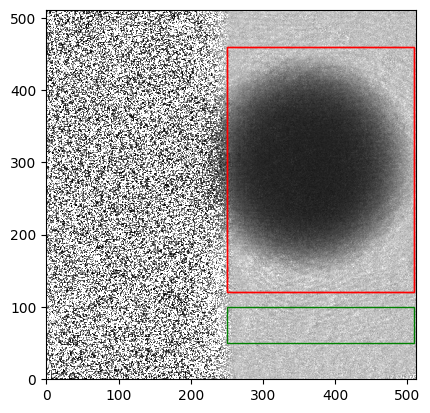

Displaying image: 
C:/Users/huanium/Desktop/sample_data/odt_lf_res\1242636_2023-02-03--11-43-13_Side.fits

Frame type: FakeOD


In [173]:
# ROI Box and norm_box for MT LF
#...

# ROI Box and norm_box for ODT LF
# Li LF ROI Box (ODT):
Li_LF_X_min = 250
Li_LF_X_max = 509
Li_LF_Y_min = 120
Li_LF_Y_max = 460
ROI_ODT_LF = [Li_LF_X_min, Li_LF_X_max, Li_LF_Y_min, Li_LF_Y_max]

# Li LF Norm Box (ODT):
Li_LF_X_min_norm = 250
Li_LF_X_max_norm = 509
Li_LF_Y_min_norm = 50
Li_LF_Y_max_norm = 100
norm_box_ODT_LF = [Li_LF_X_min_norm, Li_LF_X_max_norm, Li_LF_Y_min_norm, Li_LF_Y_max_norm]

# display Li LF image:
frame_type_ODT_LF = 'FakeOD'
current_file_fullpath_ODT_LF = data_frame_ODT_LF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_LF, ROI_ODT_LF, norm_box_ODT_LF, frame_type_ODT_LF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_LF)
print('')
print('Frame type: ' + frame_type_ODT_LF)

## <font color=#399FD5>Li ODT LF pixel sums</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 77.52it/s]


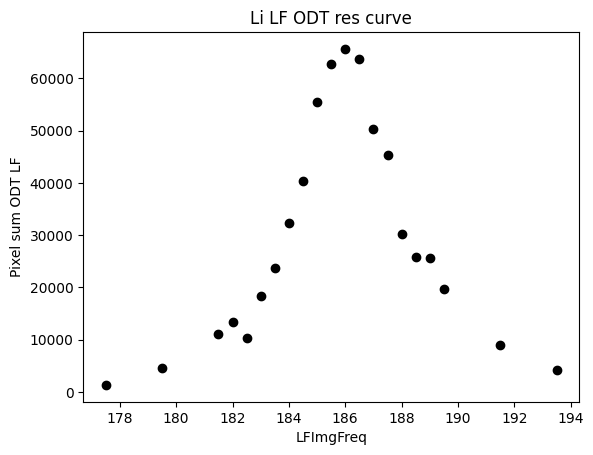

In [202]:
# compute, for each shot, a pixel sum
data_frame_ODT_LF = add_pixel_sums_to_data_frame(data_frame_ODT_LF, 
                                                 ROI_ODT_LF, 
                                                 norm_box_ODT_LF,
                                                 column_name = 'pixel_sum')

# get pixel sums and RF freqs from dataframe:
pixel_sums_ODT_LF = np.array([])
img_freqs_ODT_LF = np.array([])

for index, row in data_frame_ODT_LF.iterrows():
    pixel_sums_ODT_LF = np.append(pixel_sums_ODT_LF, row['pixel_sum'])
    img_freqs_ODT_LF = np.append(img_freqs_ODT_LF, row['LFImgFreq'])

# plot pixel sums versus FreqsA
plt.scatter(img_freqs_ODT_LF, pixel_sums_ODT_LF, color='black')
plt.xlabel('LFImgFreq')
plt.ylabel('Pixel sum ODT LF')
plt.title('Li LF ODT res curve')
plt.show()

## <font color=#399FD5>Li ODT LF resonance curve fitting</font>

----------Fit result----------------
Amplitude: 66577.69 +/- 1916.47
Center: -372.08 +/- 0.09
Gamma prime: 7.87 +/- 0.45
Offset: 0.00 +/- 1609.44
Calculated saturation parameter: 0.79
------------------------------------
Set value in Cicero to: 186.04


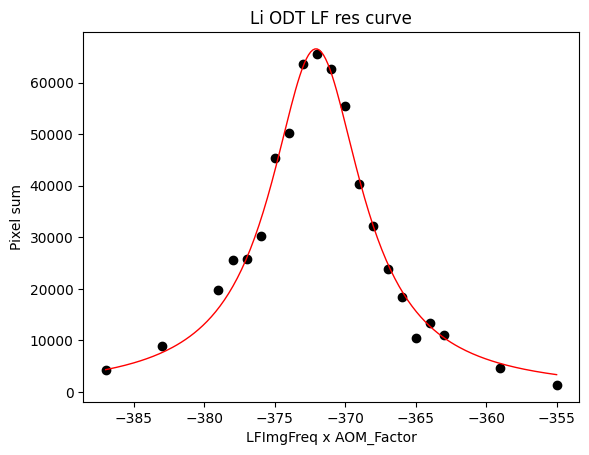

{'amplitude': 66577.68795283322, 'center': -372.07671047535933, 'gamma prime': 7.8667423220129535, 'offset': 2.2095349515465848e-16, 'calculated saturation parameter': 0.7945625065251336}


In [203]:
# ODT LF: 
center_guess_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_res_freq']
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']

fit_result_ODT_LF = Li_resonance_imaging_curve_fit(img_freqs_ODT_LF, 
                               pixel_sums_ODT_LF, 
                               AOM_factor_ODT_LF,
                               center_guess_ODT_LF,
                               plot_xlabel = 'LFImgFreq x AOM_Factor',
                               plot_title = 'Li ODT LF res curve')

print(fit_result_ODT_LF)

## <font color=#399FD5>Li ODT LF atom counting</font>

Calculating atom densities...


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 58.78it/s]


Calculating atom counts...


100%|████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2622.69it/s]


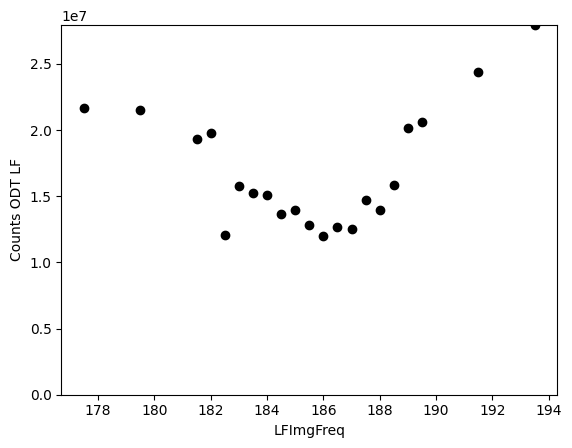

In [204]:
# get imaging parameters here:
AOM_factor_ODT_LF = experiment_parameters_dict_ODT_LF["Values"]['li_lf_freq_multiplier']
omega0_ODT_LF = fit_result_ODT_LF['center']/AOM_factor_ODT_LF
saturation_parameter_ODT_LF = fit_result_ODT_LF['calculated saturation parameter']
um_per_pixel_ODT_LF = experiment_parameters_dict_ODT_LF['Values']['side_low_mag_um_per_pixel'] # in um


# get densities:
print('Calculating atom densities...')
data_frame_ODT_LF = add_atom_densities_abs_to_data_frame_Side(data_frame_ODT_LF, 
                                                         ROI_ODT_LF, 
                                                         norm_box_ODT_LF,
                                                         sigma0 = Li6D2sigma0,
                                                         Gamma = Li6D2Gamma, 
                                                         s = saturation_parameter_ODT_LF, 
                                                         omega0 = omega0_ODT_LF,
                                                         AOM_factor = AOM_factor_ODT_LF)

# now get counts from this:
print('Calculating atom counts...')
data_frame_ODT_LF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_LF, 
                                                                 ROI_ODT_LF, 
                                                                 norm_box_ODT_LF,
                                                                 um_per_pixel_ODT_LF)

atom_counts_ODT_LF = np.array([])

for index, row in data_frame_ODT_LF.iterrows():
    atom_counts_ODT_LF = np.append(atom_counts_ODT_LF, row['atom_count'])
        
# things get funny near saturation... also looks wrong without normalization....
plt.scatter(img_freqs_ODT_LF, atom_counts_ODT_LF, color = 'black')
plt.ylim([0, max(atom_counts_ODT_LF)])
plt.xlabel('LFImgFreq')
plt.ylabel('Counts ODT LF')
plt.show()

# Li Side high magnification

# Li HF Top Absorption Imaging

## <font color=#399FD5>Data preview and preparation</font>

In [187]:
# select folder
folder_path_ODT_HF = filedialog.askdirectory()

# load metadata if avalable:
metadata_fullpath_load_status_ODT_HF = False
metadata_fullpath_ODT_HF = folder_path_ODT_HF + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_ODT_HF):
    metadata_fullpath_load_status_ODT_HF = True
    with open(metadata_fullpath_ODT_HF, 'r') as json_file:
        metadata_dict_ODT_HF = json.load(json_file)  
    
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_load_status_ODT_HF = False
experiment_parameters_fullpath_ODT_HF = folder_path_ODT_HF + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_ODT_HF):
    experiment_parameters_fullpath_load_status_ODT_HF = True
    with open(experiment_parameters_fullpath_ODT_HF, 'r') as json_file:
        experiment_parameters_dict_ODT_HF = json.load(json_file)  
        
# construct data frame with full paths:
image_list_ODT_HF = sorted(glob.glob(folder_path_ODT_HF + '/*.fits'))
data_frame_ODT_HF = pd.DataFrame(data = {'fullpaths' : image_list_ODT_HF})

# get file names for readability and attach to data frame:
# also get image type: TopA, TopB, Side
run_ids_ODT_HF = []
image_type_ODT_HF = []
ImagFreq1_ODT_HF = []
ImagFreq2_ODT_HF = []

for f in tqdm(image_list_ODT_HF):
    # add run_id
    name = str(f.split(folder_path_ODT_HF)[1]).replace('\\',"")
    run_id = name.split('_')[0] 
    run_id = "".join(ch for ch in run_id if ch.isalnum() )
    run_ids_ODT_HF.append(run_id)
    
    # add image type
    if 'TopA' in name:
        image_type_ODT_HF.append('TopA')
    elif 'TopB' in name:
        image_type_ODT_HF.append('TopB')
    elif 'Side' in name:
        image_type_ODT_HF.append('Side')
        
    # add ImagFreq:
    ImagFreq1_ODT_HF.append(get_run_param_from_filename(folder_path_ODT_HF, f, 'ImagFreq1'))
    ImagFreq2_ODT_HF.append(get_run_param_from_filename(folder_path_ODT_HF, f, 'ImagFreq2'))
        
data_frame_ODT_HF['run_id'] = run_ids_ODT_HF
data_frame_ODT_HF['image_type'] = image_type_ODT_HF
data_frame_ODT_HF['ImagFreq1'] = ImagFreq1_ODT_HF
data_frame_ODT_HF['ImagFreq2'] = ImagFreq2_ODT_HF

# add good/bad shot status to dataframe... will modify later if necessary:
data_frame_ODT_HF['good_shot'] = [True for i in range(len(image_list_ODT_HF))]

##################################################
#### PRINT OUT STATUS ############################
##################################################

print('Current folder: ' + folder_path_ODT_HF)
if metadata_fullpath_load_status_ODT_HF:
    print('Metadata loaded')
else:
    print('No metadata to load') 
if experiment_parameters_fullpath_load_status_ODT_HF:
    print('Experiment parameters loaded')
else:
    print('No experiment parameters to load')
print('Data frame initialized!')

data_frame_ODT_HF


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 320.30it/s]

Current folder: C:/Users/huanium/Desktop/sample_data/odt_hf_res
Metadata loaded
Experiment parameters loaded
Data frame initialized!


,fullpaths,run_id,image_type,ImagFreq1,ImagFreq2,good_shot
0,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235160,TopA,155.29,236.14,True
1,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235160,TopB,155.29,236.14,True
2,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235162,TopA,157.29,238.14,True
3,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235162,TopB,157.29,238.14,True
4,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235164,TopA,152.79,233.64,True
5,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235164,TopB,152.79,233.64,True
6,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235167,TopA,151.79,232.64,True
7,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235167,TopB,151.79,232.64,True
8,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235169,TopA,153.29,234.14,True
9,C:/Users/huanium/Desktop/sample_data/odt_hf_re...,1235169,TopB,153.29,234.14,True


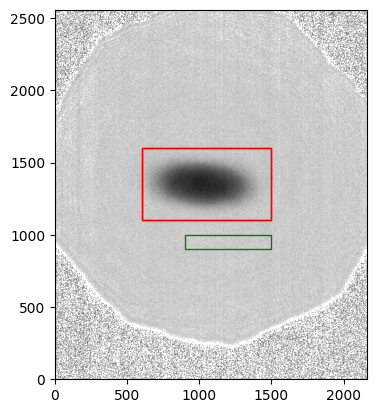

Displaying image: 
C:/Users/huanium/Desktop/sample_data/odt_hf_res\1235160_2023-01-24--11-19-23_TopA.fits

Frame type: FakeOD


In [188]:
# ROI Box and norm_box for ODT HF
# Li HF ROI Box (ODT):
Li_HF_ODT_X_min = 600
Li_HF_ODT_X_max = 1500
Li_HF_ODT_Y_min = 1100
Li_HF_ODT_Y_max = 1600
ROI_ODT_HF = [Li_HF_ODT_X_min, Li_HF_ODT_X_max, Li_HF_ODT_Y_min, Li_HF_ODT_Y_max]

# Li HF Norm Box (ODT):
Li_HF_ODT_X_min_norm = 900
Li_HF_ODT_X_max_norm = 1500
Li_HF_ODT_Y_min_norm = 900
Li_HF_ODT_Y_max_norm = 1000
norm_box_ODT_HF = [Li_HF_ODT_X_min_norm, Li_HF_ODT_X_max_norm, Li_HF_ODT_Y_min_norm, Li_HF_ODT_Y_max_norm]

# display Li LF image:
frame_type_ODT_HF = 'FakeOD'
current_file_fullpath_ODT_HF = data_frame_ODT_HF['fullpaths'][0]
fig, ax = display_image(current_file_fullpath_ODT_HF, ROI_ODT_HF, norm_box_ODT_HF, frame_type_ODT_HF)

#################################################
print('Displaying image: ')
print(current_file_fullpath_ODT_HF)
print('')
print('Frame type: ' + frame_type_ODT_HF)

## <font color=#399FD5>Li ODT HF pixel sums</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.34it/s]


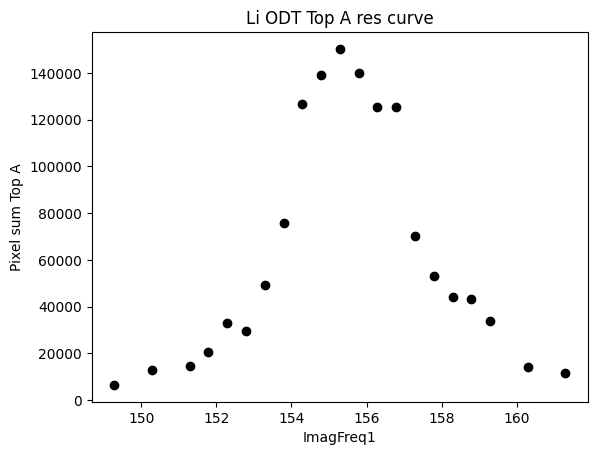

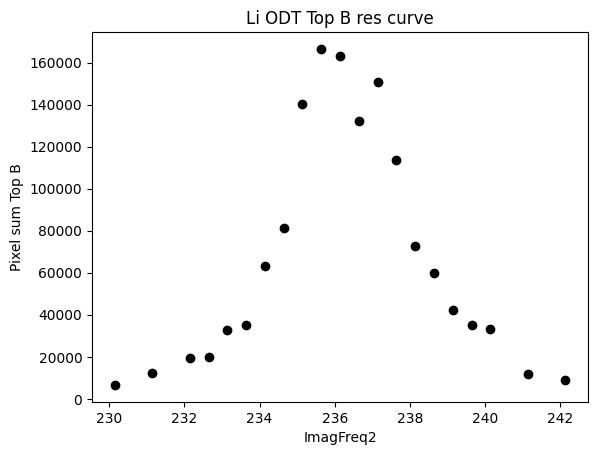

In [189]:
# compute, for each shot, a pixel sum
data_frame_ODT_HF = add_pixel_sums_to_data_frame(data_frame_ODT_HF, 
                                                 ROI_ODT_HF, 
                                                 norm_box_ODT_HF,
                                                 column_name = 'pixel_sum')

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_ODT_HF = np.array([])
pixel_sums_B_ODT_HF = np.array([])
img_freqs_A_ODT_HF = np.array([])
img_freqs_B_ODT_HF = np.array([])

for index, row in data_frame_ODT_HF.iterrows():
    if row['image_type'] == 'TopA':
        pixel_sums_A_ODT_HF = np.append(pixel_sums_A_ODT_HF, row['pixel_sum'])
        img_freqs_A_ODT_HF = np.append(img_freqs_A_ODT_HF, row['ImagFreq1'])
    elif row['image_type'] == 'TopB':
        pixel_sums_B_ODT_HF = np.append(pixel_sums_B_ODT_HF, row['pixel_sum'])
        img_freqs_B_ODT_HF = np.append(img_freqs_B_ODT_HF, row['ImagFreq2'])

# plot pixel sums versus FreqsA
plt.scatter(img_freqs_A_ODT_HF, pixel_sums_A_ODT_HF, color='black')
plt.xlabel('ImagFreq1')
plt.ylabel('Pixel sum Top A')
plt.title('Li ODT Top A res curve')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(img_freqs_B_ODT_HF, pixel_sums_B_ODT_HF, color='black')
plt.xlabel('ImagFreq2')
plt.ylabel('Pixel sum Top B')
plt.title('Li ODT Top B res curve')
plt.show()

## <font color=#399FD5>Li ODT HF resonance curve fitting</font>

----------Fit result----------------
Amplitude: 156415.14 +/- 8035.92
Center: -311.04 +/- 0.15
Gamma prime: 6.96 +/- 0.75
Offset: 0.00 +/- 6829.30
Calculated saturation parameter: 0.40
------------------------------------
Set value in Cicero to: 155.52


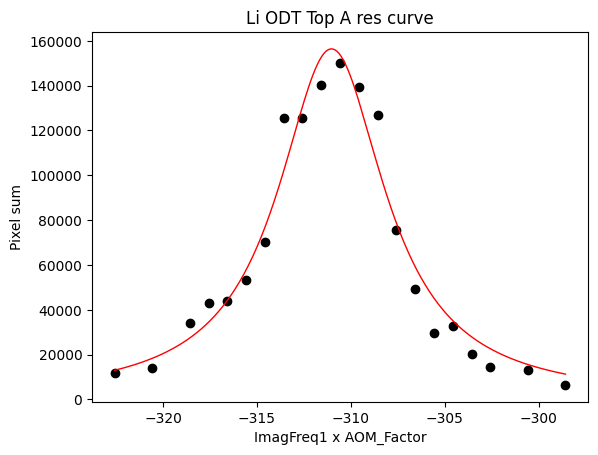

----------Fit result----------------
Amplitude: 170053.62 +/- 9275.77
Center: -472.48 +/- 0.15
Gamma prime: 6.78 +/- 0.78
Offset: 0.00 +/- 7726.46
Calculated saturation parameter: 0.33
------------------------------------
Set value in Cicero to: 236.24


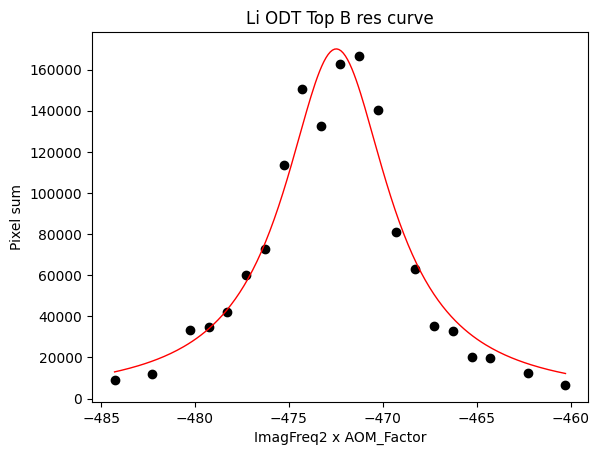

In [190]:
# ODT Top: 
center_guess_A = experiment_parameters_dict_ODT_HF['Values']['state_1_unitarity_res_freq_MHz']
center_guess_B = experiment_parameters_dict_ODT_HF['Values']['state_3_unitarity_res_freq_MHz']
AOM_factor = experiment_parameters_dict_ODT_HF['Values']['li_hf_freq_multiplier']

# Top A
fit_result_TopA = Li_resonance_imaging_curve_fit(img_freqs_A_ODT_HF, 
                               pixel_sums_A_ODT_HF, 
                               AOM_factor,
                               center_guess_A,       
                               plot_xlabel = 'ImagFreq1 x AOM_Factor',
                               plot_title = 'Li ODT Top A res curve')

# Top B
fit_result_TopB = Li_resonance_imaging_curve_fit(img_freqs_B_ODT_HF, 
                               pixel_sums_B_ODT_HF, 
                               AOM_factor,
                               center_guess_B,
                               plot_xlabel = 'ImagFreq2 x AOM_Factor',
                               plot_title = 'Li ODT Top B res curve')

#print(fit_result_TopA)
#print(fit_result_TopB)

## <font color=#399FD5>Li ODT HF atom counting</font>

A few comments:

Notice the dip? That's due to saturation. Corrections have been applied to take saturation into account but it is still not perfect. Also without normalization we could be losing some contrast. Will take this into account soon.

Calculating atom densities...


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:13<00:00,  3.03it/s]


Calculating atom counts...


100%|████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 1398.70it/s]


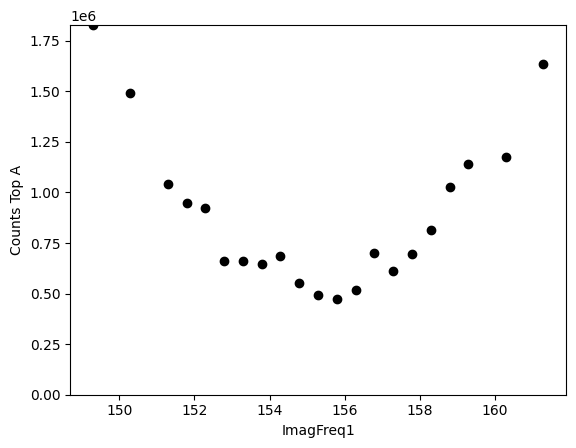

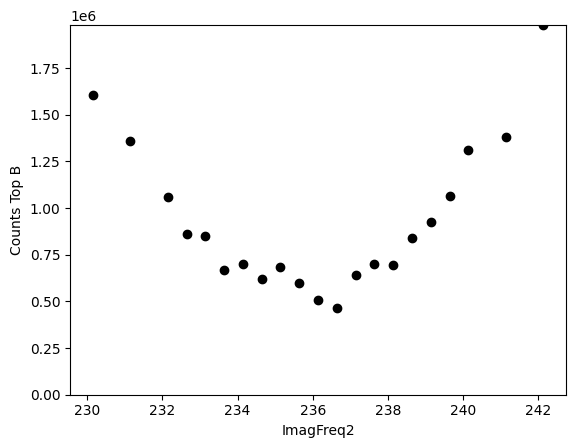

In [191]:
# get imaging parameters here:
AOM_factor_ODT_HF = experiment_parameters_dict_ODT_HF["Values"]['li_hf_freq_multiplier']
omega0_ODT_HF_A = fit_result_TopA['center']/AOM_factor_ODT_HF # from fit
omega0_ODT_HF_B = fit_result_TopB['center']/AOM_factor_ODT_HF # from fit
saturation_parameter_ODT_HF_A = fit_result_TopA['calculated saturation parameter'] # from fit
saturation_parameter_ODT_HF_B = fit_result_TopB['calculated saturation parameter'] # from fit
um_per_pixel_ODT_HF = experiment_parameters_dict_ODT_HF['Values']['top_um_per_pixel'] # in um


# get densities:
print('Calculating atom densities...')
data_frame_ODT_HF = add_atom_densities_abs_to_data_frame_TopAB(data_frame_ODT_HF, 
                                                         ROI_ODT_HF, 
                                                         norm_box_ODT_HF,
                                                         sigma0 = Li6D2sigma0,
                                                         Gamma = Li6D2Gamma, 
                                                         s_A = saturation_parameter_ODT_HF_A, 
                                                         s_B = saturation_parameter_ODT_HF_B,
                                                         omega0_A = omega0_ODT_HF_A,
                                                         omega0_B = omega0_ODT_HF_B,
                                                         AOM_factor = AOM_factor_ODT_HF)

# now get counts from this:
print('Calculating atom counts...')
data_frame_ODT_HF = add_atom_counts_from_densities_to_data_frame(data_frame_ODT_HF, 
                                                                 ROI_ODT_HF, 
                                                                 norm_box_ODT_HF,
                                                                 um_per_pixel_ODT_HF)

atom_counts_ODT_HF_A = np.array([])
atom_counts_ODT_HF_B = np.array([])

for index, row in data_frame_ODT_HF.iterrows():
    if row['image_type'] == 'TopA':
        atom_counts_ODT_HF_A = np.append(atom_counts_ODT_HF_A, row['atom_count'])
    elif row['image_type'] == 'TopB':
        atom_counts_ODT_HF_B = np.append(atom_counts_ODT_HF_B, row['atom_count'])

        
# things get funny near saturation... also looks wrong without normalization....
plt.scatter(img_freqs_A_ODT_HF, atom_counts_ODT_HF_A, color = 'black')
plt.ylim([0, max(atom_counts_ODT_HF_A)])
plt.xlabel('ImagFreq1')
plt.ylabel('Counts Top A')
plt.show()

plt.scatter(img_freqs_B_ODT_HF, atom_counts_ODT_HF_B, color = 'black')
plt.ylim([0, max(atom_counts_ODT_HF_B)])
plt.xlabel('ImagFreq2')
plt.ylabel('Counts Top B')
plt.show()

# Li HF Top Polarization Rotation

# RF Spectroscopy

## <font color=#399FD5>Data preview and preparation</font>

In [192]:
# select folder
folder_path_RF_spec = filedialog.askdirectory()

# load metadata if avalable:
metadata_fullpath_load_status_RF_spec = False
metadata_fullpath_RF_spec = folder_path_RF_spec + "/run_params_dump.json"
if os.path.isfile(metadata_fullpath_RF_spec):
    metadata_fullpath_load_status_RF_spec = True
    with open(metadata_fullpath_RF_spec, 'r') as json_file:
        metadata_dict_RF_spec = json.load(json_file)  
    
# load experiment_parameters if avaiable:
experiment_parameters_fullpath_load_status_RF_spec = False
experiment_parameters_fullpath_RF_spec = folder_path_RF_spec + "/experiment_parameters.json"
if os.path.isfile(experiment_parameters_fullpath_RF_spec):
    experiment_parameters_fullpath_load_status_RF_spec = True
    with open(experiment_parameters_fullpath_RF_spec, 'r') as json_file:
        experiment_parameters_dict_RF_spec = json.load(json_file)  
        
# construct data frame with full paths:
image_list_RF_spec = sorted(glob.glob(folder_path_RF_spec + '/*.fits'))
data_frame_RF_spec = pd.DataFrame(data = {'fullpaths' : image_list_RF_spec})

# get file names for readability and attach to data frame:
# also get image type: TopA, TopB, Side
run_ids_RF_spec = []
image_type_RF_spec = []
ImagFreq1_RF_spec = []
ImagFreq2_RF_spec = []
for f in tqdm(image_list_RF_spec):
    # add run_id
    name = str(f.split(folder_path_RF_spec)[1]).replace('\\',"")
    run_id = name.split('_')[0] 
    run_id = "".join(ch for ch in run_id if ch.isalnum() )
    run_ids_RF_spec.append(run_id)
    
    # add image type
    if 'TopA' in name:
        image_type_RF_spec.append('TopA')
    elif 'TopB' in name:
        image_type_RF_spec.append('TopB')
    elif 'Side' in name:
        image_type_RF_spec.append('Side')
        
    # add ImagFreq:
    ImagFreq1_RF_spec.append(get_run_param_from_filename(folder_path_RF_spec, f, 'ImagFreq1'))
    ImagFreq2_RF_spec.append(get_run_param_from_filename(folder_path_RF_spec, f, 'ImagFreq2'))
        
data_frame_RF_spec['run_id'] = run_ids_RF_spec
data_frame_RF_spec['image_type'] = image_type_RF_spec
data_frame_RF_spec['ImagFreq1'] = ImagFreq1_RF_spec
data_frame_RF_spec['ImagFreq2'] = ImagFreq2_RF_spec

    
# add relevant parameters to dataframe... can always add more later:
run_params_RF_spec = get_run_params_for_data_frame(folder_path_RF_spec, ['RF12_Box_Center', 'SpectPulseTime'])
# add good/bad shot status to dataframe... will modify later if necessary:
data_frame_RF_spec['good_shot'] = [True for i in range(len(image_list_RF_spec))]

# add data to dataframe:
for param in run_params_RF_spec.keys():
    data_frame_RF_spec[param] = run_params_RF_spec[param]

##################################################
#### PRINT OUT STATUS ############################
##################################################

print('Current folder: ' + folder_path_RF_spec)
if metadata_fullpath_load_status_RF_spec:
    print('Metadata loaded')
else:
    print('No metadata to load') 
if experiment_parameters_fullpath_load_status_RF_spec:
    print('Experiment parameters loaded')
else:
    print('No experiment parameters to load')
print('Data frame initialized!')

data_frame_RF_spec

##################################################

100%|█████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 177.33it/s]

Current folder: C:/Users/huanium/Desktop/sample_data/rf12_spect
Metadata loaded
Experiment parameters loaded
Data frame initialized!


,fullpaths,run_id,image_type,ImagFreq1,ImagFreq2,good_shot,RF12_Box_Center,SpectPulseTime
0,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138110,TopA,155.35,193.45,True,76.0330,1.0
1,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138110,TopB,155.35,193.45,True,76.0330,1.0
2,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138113,TopA,155.35,193.45,True,76.0320,1.0
3,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138113,TopB,155.35,193.45,True,76.0320,1.0
4,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138116,TopA,155.35,193.45,True,76.0340,1.0
...,...,...,...,...,...,...,...,...
77,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138276,TopB,155.35,193.45,True,76.0314,1.0
78,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138279,TopA,155.35,193.45,True,76.0326,1.0
79,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138279,TopB,155.35,193.45,True,76.0326,1.0
80,C:/Users/huanium/Desktop/sample_data/rf12_spec...,1138282,TopA,155.35,193.45,True,76.0328,1.0


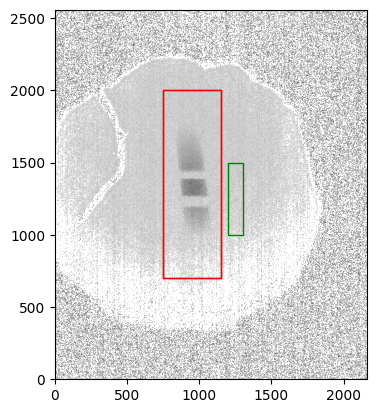

Displaying image: 
C:/Users/huanium/Desktop/sample_data/rf12_spect\1138110_2022-09-26--15-39-50_TopA.fits

Frame type: FakeOD


In [193]:
# ROI Box and norm_box for RF spec
# Li RF spec ROI Box:
Li_RF_spec_X_min = 750
Li_RF_spec_X_max = 1150
Li_RF_spec_Y_min = 700
Li_RF_spec_Y_max = 2000
ROI_Li_RF_spec = [Li_RF_spec_X_min, Li_RF_spec_X_max, Li_RF_spec_Y_min, Li_RF_spec_Y_max]

# Li RF spec Norm Box:
Li_RF_spec_X_min_norm = 1200
Li_RF_spec_X_max_norm = 1300
Li_RF_spec_Y_min_norm = 1000
Li_RF_spec_Y_max_norm = 1500
norm_box_Li_RF_spec = [Li_RF_spec_X_min_norm, Li_RF_spec_X_max_norm, Li_RF_spec_Y_min_norm, Li_RF_spec_Y_max_norm]

# display some Li RF spec image:
frame_type_Li_RF_spec = 'FakeOD'
current_file_fullpath_Li_RF_spec = data_frame_RF_spec['fullpaths'][0]
fig_RF_spec, ax_RF_spec = display_image(current_file_fullpath_Li_RF_spec, ROI_Li_RF_spec, norm_box_Li_RF_spec, frame_type_Li_RF_spec)

#################################################
print('Displaying image: ')
print(current_file_fullpath_Li_RF_spec)
print('')
print('Frame type: ' + frame_type_Li_RF_spec)

## <font color=#399FD5>Li RF transfer from pixel sum</font>

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:22<00:00,  3.62it/s]


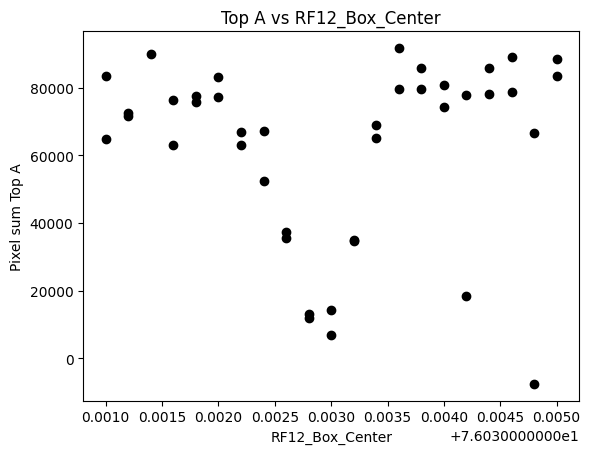

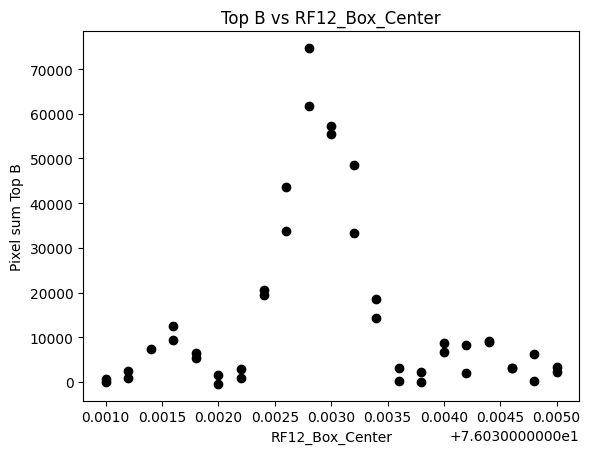

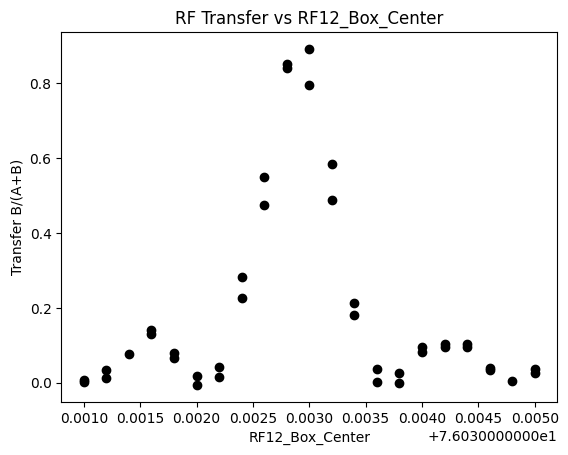

In [205]:
# compute, for each shot, a pixel sum
data_frame_RF_spec = add_pixel_sums_to_data_frame(data_frame_RF_spec, 
                                                  ROI_Li_RF_spec, 
                                                  norm_box_Li_RF_spec,
                                                  column_name = 'pixel_sum')

# get pixel sums and RF freqs from dataframe:
pixel_sums_A_RF = np.array([])
pixel_sums_B_RF = np.array([])
RF_freqs_A = np.array([])
RF_freqs_B = np.array([])

for index, row in data_frame_RF_spec.iterrows():
    if row['image_type'] == 'TopA':
        pixel_sums_A_RF = np.append(pixel_sums_A_RF, row['pixel_sum'])
        RF_freqs_A = np.append(RF_freqs_A, row['RF12_Box_Center'])
    elif row['image_type'] == 'TopB':
        pixel_sums_B_RF = np.append(pixel_sums_B_RF, row['pixel_sum'])
        RF_freqs_B = np.append(RF_freqs_B, row['RF12_Box_Center'])
        
# compute RF_transfer:
RF_transfer_pixel_sum = pixel_sums_B_RF/(pixel_sums_A_RF + pixel_sums_B_RF)

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_A, pixel_sums_A_RF, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top A')
plt.title('Top A vs RF12_Box_Center')
plt.show()

# plot pixel sums versus FreqsA
plt.scatter(RF_freqs_B, pixel_sums_B_RF, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Pixel sum Top B')
plt.title('Top B vs RF12_Box_Center')
plt.show()

# filter data:
filtered_RF_freqs_A, filtered_RF_transfer_pixel_sum = generic_data_filter(RF_freqs_A, RF_transfer_pixel_sum, 2)

# plot transfer, using pixel sums:
plt.scatter(filtered_RF_freqs_A, filtered_RF_transfer_pixel_sum, color='black')
plt.xlabel('RF12_Box_Center')
plt.ylabel('Transfer B/(A+B)')
plt.title('RF Transfer vs RF12_Box_Center')
plt.show()


## <font color=#399FD5>Li RF transfer from atom count</font>

Notice in the output below that without background "normalization" we lose contrast in atom density. 

Calculating atom densities...


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:30<00:00,  2.67it/s]


Calculating atom counts...


100%|█████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 811.16it/s]


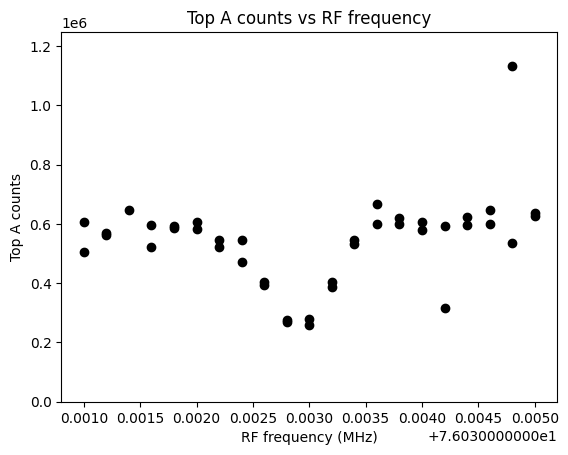

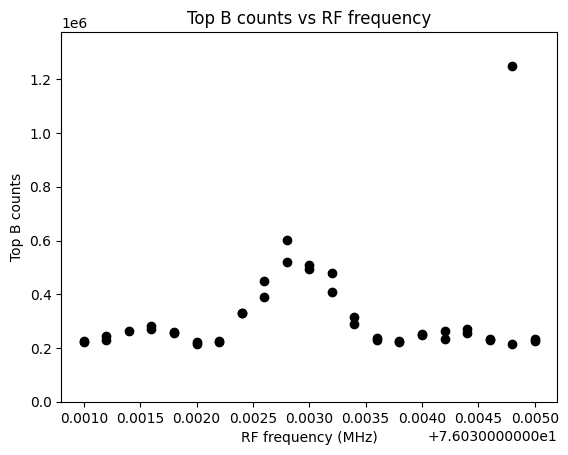

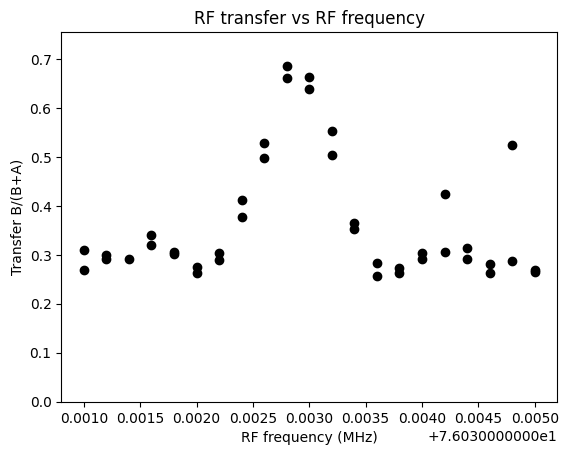

In [206]:
# get imaging parameters here:
AOM_factor_RF_spec = experiment_parameters_dict_RF_spec["Values"]['li_hf_freq_multiplier']
omega0_RF_spec_A = experiment_parameters_dict_RF_spec["Values"]['state_1_unitarity_res_freq_MHz']
omega0_RF_spec_B = experiment_parameters_dict_RF_spec["Values"]['state_2_unitarity_res_freq_MHz']
saturation_parameter_RF_spec_A = 0 # unknown, so assume 0
saturation_parameter_RF_spec_B = 0 # unknown, so assume 0
um_per_pixel_RF_spec = experiment_parameters_dict_RF_spec['Values']['top_um_per_pixel'] # in um

# get densities:
print('Calculating atom densities...')
data_frame_RF_spec = add_atom_densities_abs_to_data_frame_TopAB(data_frame_RF_spec, 
                                                          ROI_Li_RF_spec, 
                                                          norm_box_Li_RF_spec, 
                                                          sigma0 = Li6D2sigma0,
                                                          Gamma = Li6D2Gamma, 
                                                          s_A = saturation_parameter_RF_spec_A, 
                                                          s_B = saturation_parameter_RF_spec_B,
                                                          omega0_A = omega0_RF_spec_A,
                                                          omega0_B = omega0_RF_spec_B,
                                                          AOM_factor = AOM_factor_RF_spec)

# now get counts from this:
print('Calculating atom counts...')
data_frame_RF_spec = add_atom_counts_from_densities_to_data_frame(data_frame_RF_spec, 
                                                                  ROI_Li_RF_spec, 
                                                                  norm_box_Li_RF_spec, 
                                                                  um_per_pixel_RF_spec)

# get RF_transfers from counts:
atom_counts_RF_spec_A = np.array([])
atom_counts_RF_spec_B = np.array([])
RF_freqs_A_cts = np.array([])
RF_freqs_B_cts = np.array([])

for index, row in data_frame_RF_spec.iterrows():
    if row['image_type'] == 'TopA':
        atom_counts_RF_spec_A = np.append(atom_counts_RF_spec_A, row['atom_count'])
        RF_freqs_A_cts = np.append(RF_freqs_A_cts, row['RF12_Box_Center'])
    elif row['image_type'] == 'TopB':
        atom_counts_RF_spec_B = np.append(atom_counts_RF_spec_B, row['atom_count'])
        RF_freqs_B_cts = np.append(RF_freqs_B_cts, row['RF12_Box_Center'])
        
# compute RF_transfer:
RF_transfer_counts = atom_counts_RF_spec_B/(atom_counts_RF_spec_A + atom_counts_RF_spec_B)

# atom counts vs RF freq
plt.scatter(RF_freqs_A_cts, atom_counts_RF_spec_A, color = 'black')
plt.ylim([0, 1.1 * max(atom_counts_RF_spec_A)])
plt.title('Top A counts vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Top A counts')
plt.show()

plt.scatter(RF_freqs_B_cts, atom_counts_RF_spec_B, color = 'black')
plt.ylim([0, 1.1 * max(atom_counts_RF_spec_B)])
plt.title('Top B counts vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Top B counts')
plt.show()

# plot RF transfer from atom counts:
plt.scatter(RF_freqs_A_cts, RF_transfer_counts, color = 'black')
plt.ylim([0, 1.1 * max(RF_transfer_counts)])
plt.title('RF transfer vs RF frequency')
plt.xlabel('RF frequency (MHz)')
plt.ylabel('Transfer B/(B+A)')
plt.show()

## <font color=#399FD5>Li RF resonance curve fitting</font>

Some theory for this: The exact solution to the Rabi problem (without assuming spontaneous decay) is given by 

$P_2(\tau) = \frac{\omega_R^2}{\omega_R^2 + \delta^2} \sin^2\left( \tau  \frac{\sqrt{\delta^2 + \omega_R^2} }{2} \right), $ 

where we have assumed that initially $P_1 = 1$. Here $\tau$ is the width of the RF pulse, $\Omega_R$ is the bare Rabi frequency, and $\delta$ is the detuning. The setting in our case is that we know $\tau$ and $\delta$. So, the fit will tell us $\Omega_R$. 

For now, we will attempt to fit using the RF transfer computed using pixel summing. The method should work for atom counts once it is better-calibrated (i.e. once background "normalization" has been taken into account).


In [269]:
# RF resonance curve fitting
RF_freqs = np.array(filtered_RF_freqs_A) # in MHz --> Hz
omega0_RF_guess = np.average(filtered_RF_freqs_A) # temporary, for now, in MHz
RF_transfers = RF_transfer_counts
# get pulse widths... should all be the same but ok
tau = []
d_old = dict()
for d in get_run_params(folder_path_RF_spec, ['SpectPulseTime', 'id']):
    if d != d_old:                    
        tau.append(d['SpectPulseTime'])
        d_old = d
tau = np.array(tau)
        
        
RF_freqs_and_taus = np.array([RF_freqs, tau])
# Top A
fit_result_RF_spec = Li_P2_Rabi_RF_curve_fit((RF_freqs, tau), 
                                             RF_transfer_pixel_sum, 
                                             omega0_guess = omega0_RF_guess,
                                             omegaR_guess = 0.0005, # MHz 
                                             plot_xlabel = 'RF frequency (MHz)',
                                             plot_title = 'RF Resonance Curve')

print(fit_result_RF_spec)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.